In [4]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('../data/cleaned_data.csv')
df.head()

,text,label
0,feel really helpless heavy hearted,fear
1,I enjoy able slouch relax unwind frankly need ...,sadness
2,give internship dmrg feel distraught,fear
3,know feel lose,sadness
4,kindergarten teacher thoroughly weary job take...,fear


In [11]:
df.isnull().sum()

,0
text,0
label,1


In [12]:
df.dropna(inplace=True)

In [13]:
# Encoding the label
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])

In [14]:
# Splitting the data
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train.isnull().sum()

0

## Tokenizing and Padding the sequences

In [16]:
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

maxlen = max(len(tokens) for tokens in X_train_sequences)
print('Max length of Sequence is: ', maxlen)

X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')


Max length of Sequence is:  48


In [17]:
# Size of the input
import numpy as np
input_Size = np.max(X_train_padded)+1
input_Size

46318

### Balancing the dataset since it is imbalanced

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights = dict(enumerate(weights))

## Bidirectional LSTM Training

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

model = Sequential()

model.add(Embedding(input_dim=input_Size, output_dim=100, input_shape=(78,)))
model.add(Bidirectional(LSTM(128)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 78, 100)             │       4,631,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,884,158 (18.63 MB)

 Trainable params: 4,883,646 (18.63 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
history_lstm = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, class_weight=class_weights, validation_data=(X_test_padded, y_test), callbacks=[EarlyStopping(patience=3)])

Epoch 1/10
6437/6437 ━━━━━━━━━━━━━━━━━━━━ 91s 13ms/step - accuracy: 0.8113 - loss: 0.5303 - val_accuracy: 0.9365 - val_loss: 0.1331
Epoch 2/10
6437/6437 ━━━━━━━━━━━━━━━━━━━━ 137s 13ms/step - accuracy: 0.9406 - loss: 0.1333 - val_accuracy: 0.9453 - val_loss: 0.1051
Epoch 3/10
6437/6437 ━━━━━━━━━━━━━━━━━━━━ 141s 13ms/step - accuracy: 0.9499 - loss: 0.1092 - val_accuracy: 0.9462 - val_loss: 0.1058
Epoch 4/10
6437/6437 ━━━━━━━━━━━━━━━━━━━━ 83s 13ms/step - accuracy: 0.9514 - loss: 0.0987 - val_accuracy: 0.9477 - val_loss: 0.1028
Epoch 5/10
6437/6437 ━━━━━━━━━━━━━━━━━━━━ 145s 13ms/step - accuracy: 0.9552 - loss: 0.0885 - val_accuracy: 0.9463 - val_loss: 0.1199
Epoch 6/10
6437/6437 ━━━━━━━━━━━━━━━━━━━━ 83s 13ms/step - accuracy: 0.9588 - loss: 0.0816 - val_accuracy: 0.9468 - val_loss: 0.1201
Epoch 7/10
6437/6437 ━━━━━━━━━━━━━━━━━━━━ 143s 13ms/step - accuracy: 0.9621 - loss: 0.0751 - val_accuracy: 0.9441 - val_loss: 0.1204


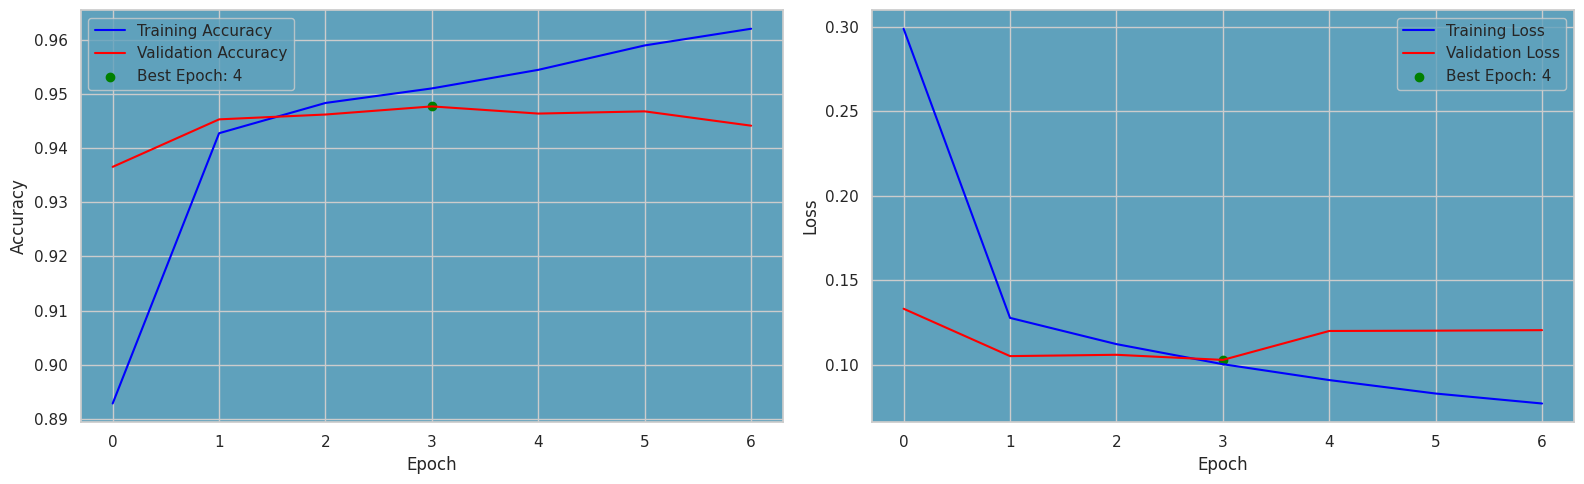

In [22]:
import matplotlib.pyplot as plt
best_epoch = history_lstm.history['val_accuracy'].index(max(history_lstm.history['val_accuracy']))+1

background_color = '#5fa1bc'
sns.set_theme(style='whitegrid', rc={'axes.facecolor': background_color})

fig, axs = plt.subplots(1,2, figsize=(16,5))

axs[0].plot(history_lstm.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history_lstm.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history_lstm.history['val_accuracy'][best_epoch-1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history_lstm.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history_lstm.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch-1, history_lstm.history['val_loss'][best_epoch-1], color='green', label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [23]:
model.evaluate(X_test_padded, y_test)

1610/1610 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9448 - loss: 0.1181


[0.12042923271656036, 0.9441110491752625]

In [24]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred  = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)
y_pred

1610/1610 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step


array([4, 2, 0, ..., 2, 2, 4])

In [25]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 6885,    50,    30,     6,    59,     2],
       [  223,  5431,    35,     7,   155,     8],
       [   48,    26, 16924,   523,    48,    31],
       [   24,    12,   443,  3480,    28,     5],
       [  295,   138,    68,    50, 14735,    13],
       [    3,   337,   201,     1,     9,  1162]])

<Axes: >

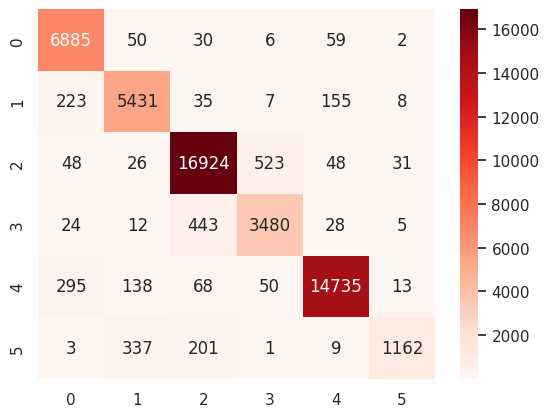

In [26]:
sns.heatmap(cm , annot=True, fmt='d', cmap='Reds')

## Bidrirection GRU

In [27]:
model = Sequential()

model.add(Embedding(input_dim=input_Size, output_dim=100, input_shape=(78,)))
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Bidirectional(GRU(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 78, 100)             │       4,631,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 78, 256)             │         176,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 78, 128)             │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 78, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 78, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,015,742 (19.13 MB)

 Trainable params: 5,015,486 (19.13 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
history_gru = model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), class_weight=class_weights, epochs=10, batch_size=50, callbacks=[EarlyStopping(patience=2)])

Epoch 1/10
4120/4120 ━━━━━━━━━━━━━━━━━━━━ 103s 24ms/step - accuracy: 0.8237 - loss: 0.4659 - val_accuracy: 0.9446 - val_loss: 0.1177
Epoch 2/10
4120/4120 ━━━━━━━━━━━━━━━━━━━━ 99s 24ms/step - accuracy: 0.9465 - loss: 0.1106 - val_accuracy: 0.9459 - val_loss: 0.1085
Epoch 3/10
4120/4120 ━━━━━━━━━━━━━━━━━━━━ 140s 24ms/step - accuracy: 0.9498 - loss: 0.0979 - val_accuracy: 0.9472 - val_loss: 0.1057
Epoch 4/10
4120/4120 ━━━━━━━━━━━━━━━━━━━━ 141s 23ms/step - accuracy: 0.9525 - loss: 0.0898 - val_accuracy: 0.9466 - val_loss: 0.1051
Epoch 5/10
4120/4120 ━━━━━━━━━━━━━━━━━━━━ 144s 24ms/step - accuracy: 0.9544 - loss: 0.0838 - val_accuracy: 0.9502 - val_loss: 0.1087
Epoch 6/10
4120/4120 ━━━━━━━━━━━━━━━━━━━━ 141s 24ms/step - accuracy: 0.9557 - loss: 0.0795 - val_accuracy: 0.9481 - val_loss: 0.1129


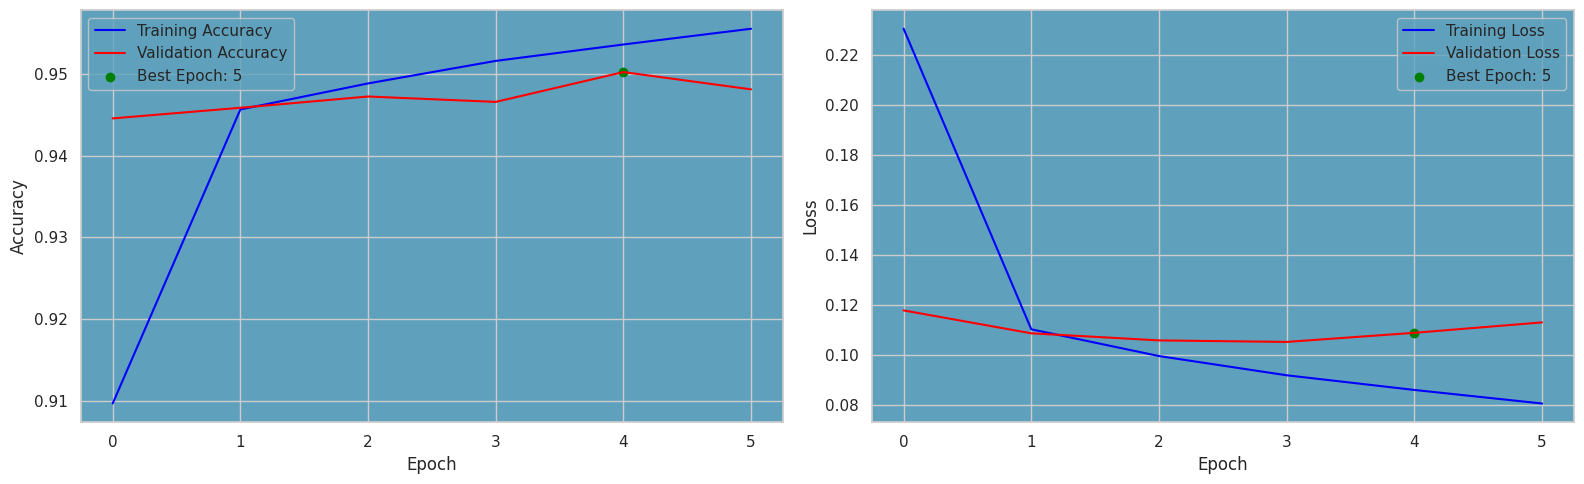

In [30]:
best_epoch = history_gru.history['val_accuracy'].index(max(history_gru.history['val_accuracy']))+1

background_color = '#5fa1bc'
sns.set_theme(style='whitegrid', rc={'axes.facecolor': background_color})

fig, axs = plt.subplots(1,2, figsize=(16,5))

axs[0].plot(history_gru.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history_gru.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history_gru.history['val_accuracy'][best_epoch-1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history_gru.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history_gru.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch-1, history_gru.history['val_loss'][best_epoch-1], color='green', label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [31]:
model.evaluate(X_test_padded, y_test)

1610/1610 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.9496 - loss: 0.1100


[0.11287334561347961, 0.9481114745140076]

In [32]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred  = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)
y_pred

1610/1610 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step


array([4, 2, 0, ..., 2, 2, 4])

In [33]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 6505,   237,    55,    10,   221,     4],
       [   28,  5403,    51,     3,    34,   340],
       [   49,    14, 17278,    93,    39,   127],
       [   16,    10,   862,  3054,    40,    10],
       [   70,   214,    79,    31, 14886,    19],
       [    1,     7,     3,     1,     4,  1697]])

<Axes: >

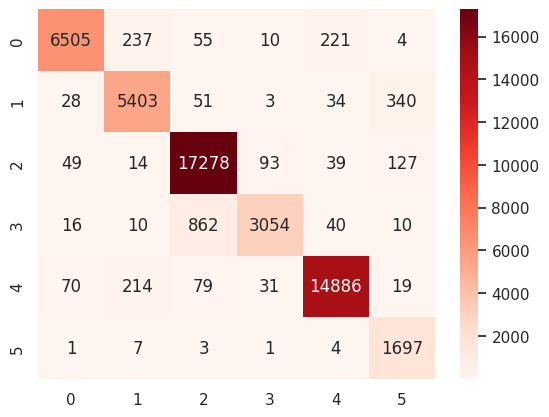

In [34]:
sns.heatmap(cm , annot=True, fmt='d', cmap='Reds')